# Housing Price Simulation.

A notebook by *List your names here*.

Then, add alternating code cells and description/markdown cells,
between this top cell and the final "Running DocTest tests" section,
to answer all the elements of the final project programming assignment.

The answer to each part must be clearly identified with,
the text "Step 1" for Step 1, "Step 2" for Step 2, etc.
As noted in the assignment, you may do some of the work in copies of this project
for different sub-experiments,
rather than just putting it all in this notebook,
if you like.

In [194]:
import numpy as np
import doctest
import matplotlib.pyplot as plt
import pandas as pd

## Data Generation

In [195]:
def gen_data(n, y_min, alpha, mu, c, seed=1):

  # Validate parameters
    if y_min <= c:
        raise ValueError("y_min needs to be greater than c")
    if alpha <= 1:
        raise ValueError("alpha neds to be greater than 1")
    if mu <= 0:
        raise ValueError("mu needs to be positive")

    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)

    y = np.sort(y)
    d = np.sort(d)
    return y, d


## Data Gen Validation

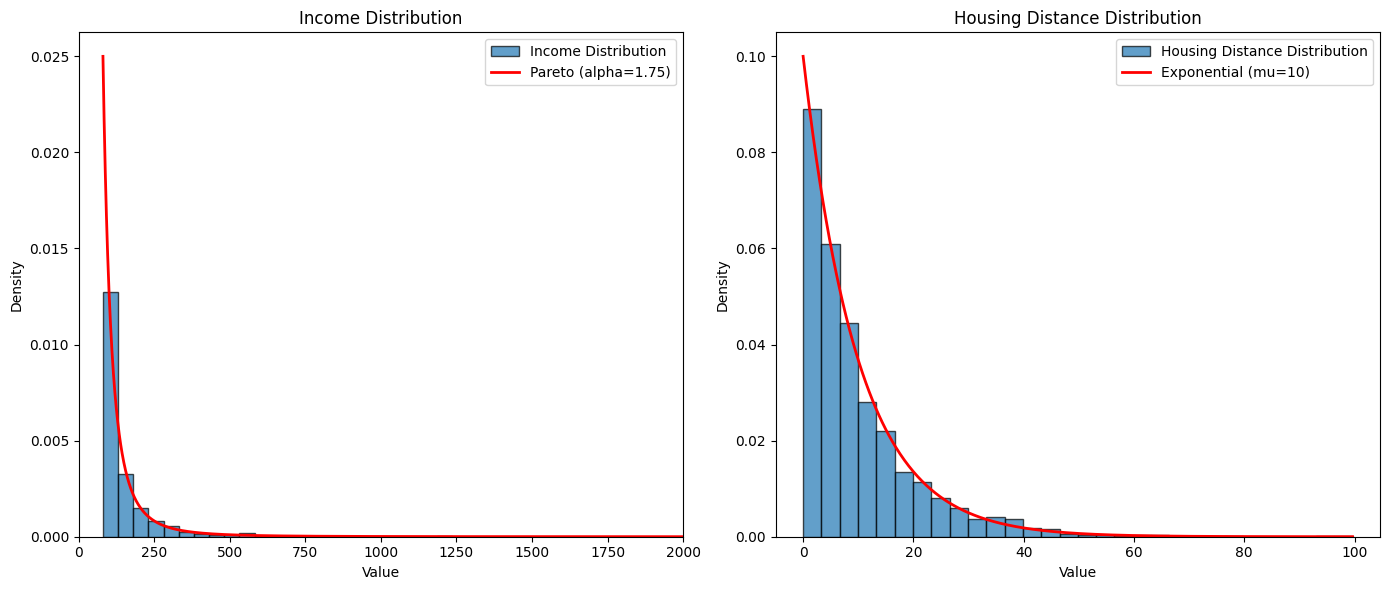

Income: [  80.0116925    80.05542882   80.06101929 ... 2236.73804462 2764.44637083
 5098.51383599]
Housing Distance: [5.44994504e-03 7.48718981e-03 1.19609491e-02 ... 7.84055577e+01
 9.44687681e+01 9.96261812e+01]


In [196]:

# PLOT DISTRIBUTIONS 

def plot_distributions(n,y_min,alpha,mu,c,seed,xlim):
    
    y,d,=gen_data(n, y_min, alpha, mu, c, seed)

    # check to see if they look pareto and exp
    
    plt.figure(figsize=(14, 6))  

    # Income Distribution
    plt.subplot(1, 2, 1)
    plt.hist(y, bins=100, density=True, alpha=0.7, edgecolor="black", label="Income Distribution")
    plt.title("Income Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.xlim(0, xlim) 

    # Add Pareto line
    pareto_x = np.linspace(y_min, xlim, xlim)
    pareto_pdf = (alpha * y_min**alpha) / (pareto_x ** (alpha + 1))
    plt.plot(pareto_x, pareto_pdf, 'r-', lw=2, label="Pareto (alpha=1.75)")
    plt.legend()

    # Housing Distance Distribution
    plt.subplot(1, 2, 2)
    plt.hist(d, bins=30, density=True, alpha=0.7, edgecolor="black", label="Housing Distance Distribution")
    plt.title("Housing Distance Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")

    # Add Exponential line
    exp_x = np.linspace(0, d.max(), 500)
    exp_pdf = (1 / mu) * np.exp(-exp_x / mu)
    plt.plot(exp_x, exp_pdf, 'r-', lw=2, label="Exponential (mu=10)")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print(f'Income: {y}')
    print(f'Housing Distance: {d}')


# Generate samples for visualization
n_test = 2000
y_min_test = 80
alpha_test = 2
mu_test = 10
c_test = 50
seed = 1


plot_distributions(n_test,y_min_test,alpha_test,mu_test,c_test,seed,xlim=2000) #xlim for readibility



## Visualization and Statistics

In [197]:
def compute_statistics(prices):
    average = np.mean(prices)
    median = np.median(prices)
    Q1 = np.percentile(prices, 25)
    Q3 = np.percentile(prices, 75)
    IQR = Q3 - Q1

    statistics = {
        'average': average,
        'median': median,
        'Q1' : Q1,
        'Q3' : Q3,
        'IQR': IQR
    }

    return statistics


def plot_house_prices(y, prices):
    n = len(y)
    income_quantiles = np.linspace(0, 1, n)

    plt.figure(figsize=(12, 6))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, color='b')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('House Price')
    plt.title('House Prices vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_percentage_income_spent(y, prices):
    n = len(y)
    income_quantiles = np.linspace(0, 1, n)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_spent = np.where(y != 0, (prices / y) * 100, 0)

    plt.figure(figsize=(10, 6))
    plt.plot(income_quantiles, percentage_spent, marker='s', linestyle='--', color='r')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('Percentage of Income Spent on Housing (%)')
    plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#plot_house_prices(y, prices)
#plot_percentage_income_spent(y, prices)
#print(compute_statistics(prices))

## 2a: basic recursion

In [198]:
def calc_prices_recursive(n, c, y, d):
    if len(y) != n or len(d) != n:
        raise ValueError("Input arrays y and d must have a length equal to n.")
    
    prices = np.zeros(n)
    prices[0] = c  # Base case: first house price is equal to c
    
    for j in range(1, n):
        theta_j = np.exp(-(d[j] - d[j - 1]))
        prices[j] = theta_j * prices[j - 1] + (1 - theta_j) * y[j]
    
    return prices

## 2b: memo

In [199]:
def calc_price_memo(n, c, y, d):
    memo = np.full(n, np.nan)
    memo[0] = c  # Base case: first price is the initial price

    def calc_equilibrum(j):
        if not np.isnan(memo[j]):
            return memo[j]

        # Calculate theta_j
        theta_j = np.exp(-(d[j] - d[j - 1]))

        # Recursive calculation for the previous price
        previous_price = calc_equilibrum(j - 1)

        # Calculate current equilibrium price
        memo[j] = theta_j * previous_price + (1 - theta_j) * y[j]
        return memo[j]

    # Compute prices for all indices
    for j in range(1, n):
        calc_equilibrum(j)

    return memo

## 2c: Iterative 

In [200]:
def calc_prices_iterative(n, c, y, d):
    prices = np.zeros(n)
    prices[0] = c  # Base case
    
    # Calculate prices iteratively
    for j in range(1, n):
        theta_j = np.exp(-(d[j] - d[j-1]))
        prices[j] = theta_j * prices[j-1] + (1 - theta_j) * y[j]
    
    return prices


## 4a

   y_min     average      median          Q1          Q3         IQR
0     80  164.964851  112.825895   87.755869  173.113008   85.357138
1    100  203.585826  139.383726  107.727324  207.404127   99.676802
2    150  332.100292  210.668020  163.492592  311.866293  148.373702


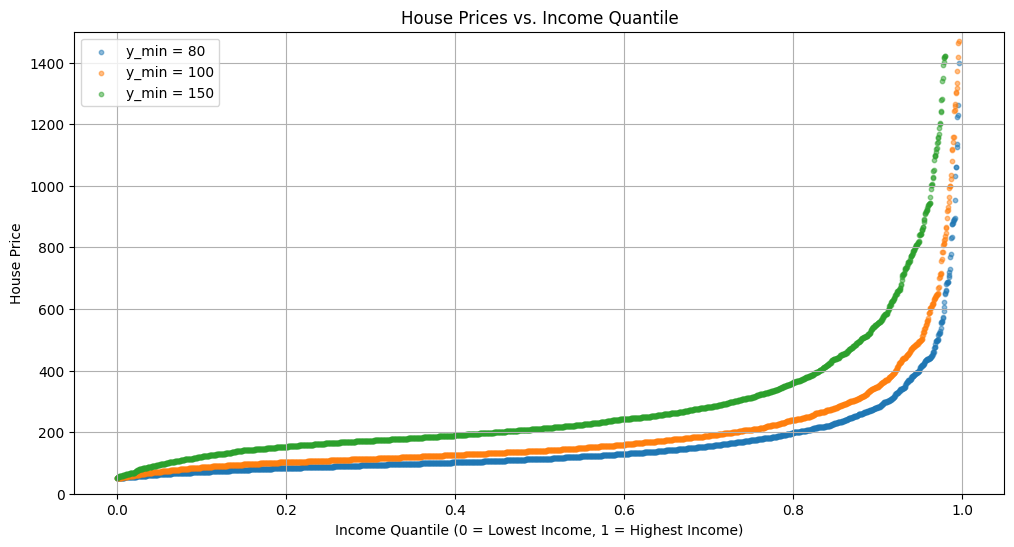

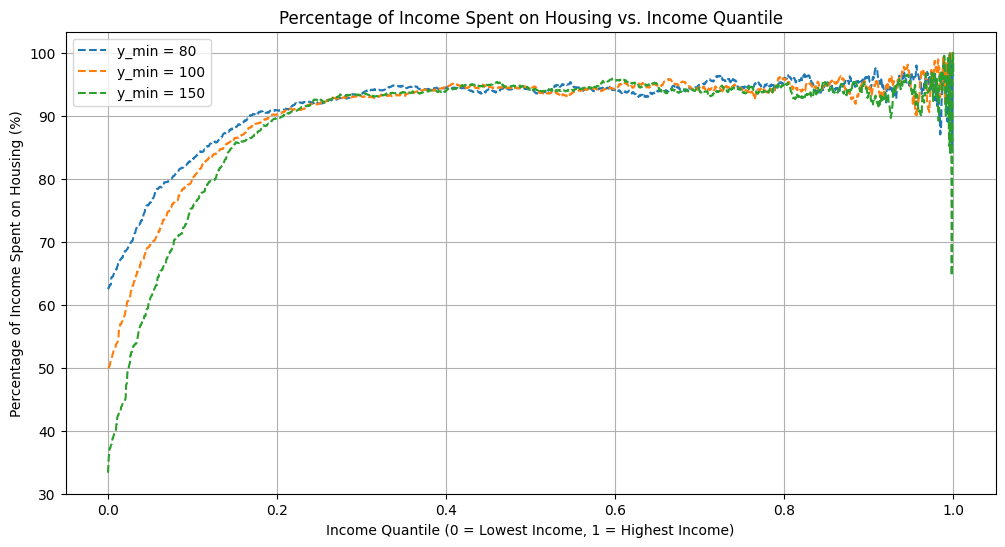

In [201]:
n = 2000
y_min_list = [80, 100, 150]
alpha = 1.75
mu = 10
c = 50
seed = 1

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices

# Iterate over each y_min value
for y_min in y_min_list:
    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d)
   
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['y_min'] = y_min  
    stats_list.append(stats)
    
    # Test base case
   # base_case_price = prices[0]  # This is the price of house j=1
   # if base_case_price == c:
   #     base_case_result = f"Base Case check passed: {base_case_price}"
  #  else:
   #     base_case_result = f"Base Case check failed: {base_case_price}"

stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['y_min', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)


# Create plots after the loop
income_quantiles = np.linspace(0, 1, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, y_min) in enumerate(zip(all_prices, y_min_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'y_min = {y_min}')
plt.ylim(0, 1500)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, y_min) in enumerate(zip(all_y, all_prices, y_min_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'y_min = {y_min}')

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()



### 4b

   alpha     average      median         Q1          Q3         IQR
0   1.25  359.962129  127.474520  91.586326  228.272661  136.686335
1   1.75  167.636406  110.888094  87.790858  165.921229   78.130372
2   3.00  113.292880   97.681499  83.653944  123.912656   40.258712


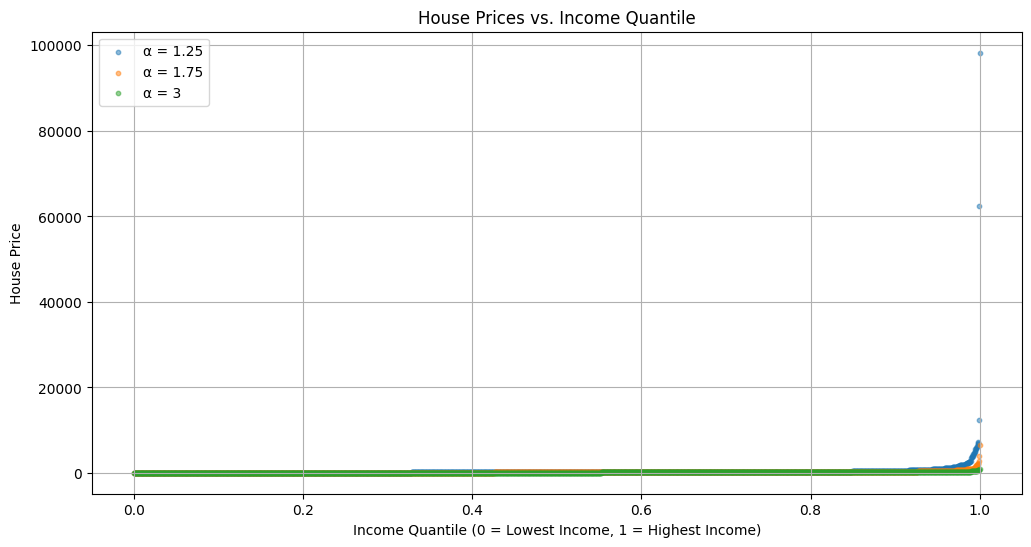

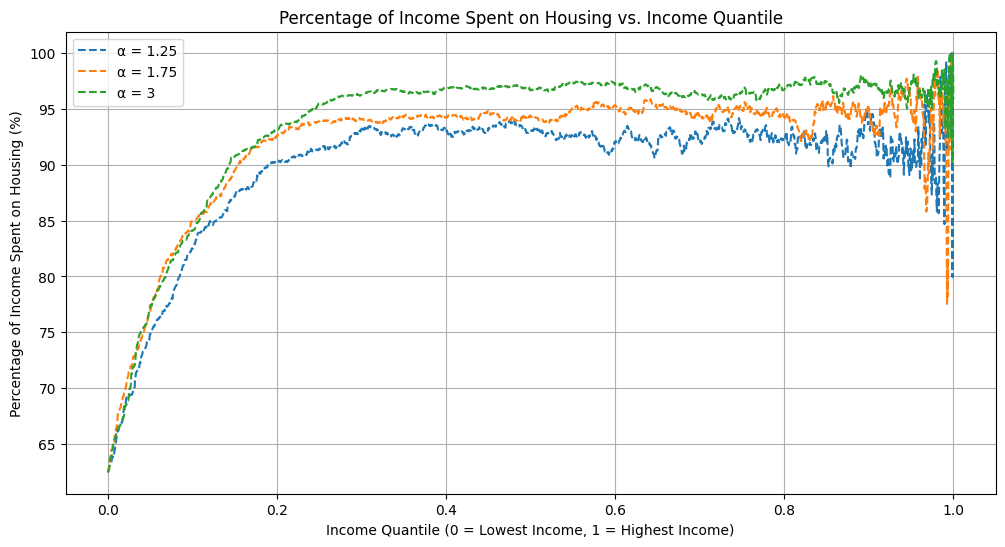

In [202]:
n = 2000
alpha_list = [1.25, 1.75, 3]
y_min = 80
mu = 10
c = 50
seed = 1

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices

# Iterate over each alpha
for alpha in alpha_list:

    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['alpha'] = alpha  
    stats_list.append(stats)

# df for table
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['alpha', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# Create plots after the loop
income_quantiles = np.linspace(0, 1, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, alpha) in enumerate(zip(all_prices, alpha_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'α = {alpha}')  

#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, alpha) in enumerate(zip(all_y, all_prices, alpha_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'α = {alpha}') 
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

### 4c

   mu     average      median         Q1          Q3        IQR
0   5  160.851488  103.314890  78.706959  151.125130  72.418171
1  10  179.860892  111.077208  86.843298  170.720268  83.876970
2  20  174.003478  116.407375  90.946203  174.516038  83.569836


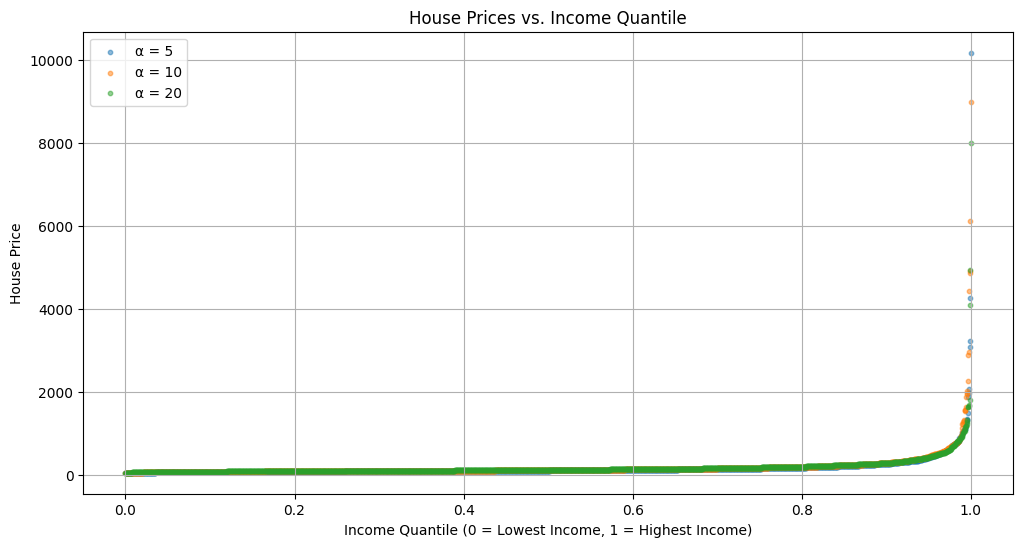

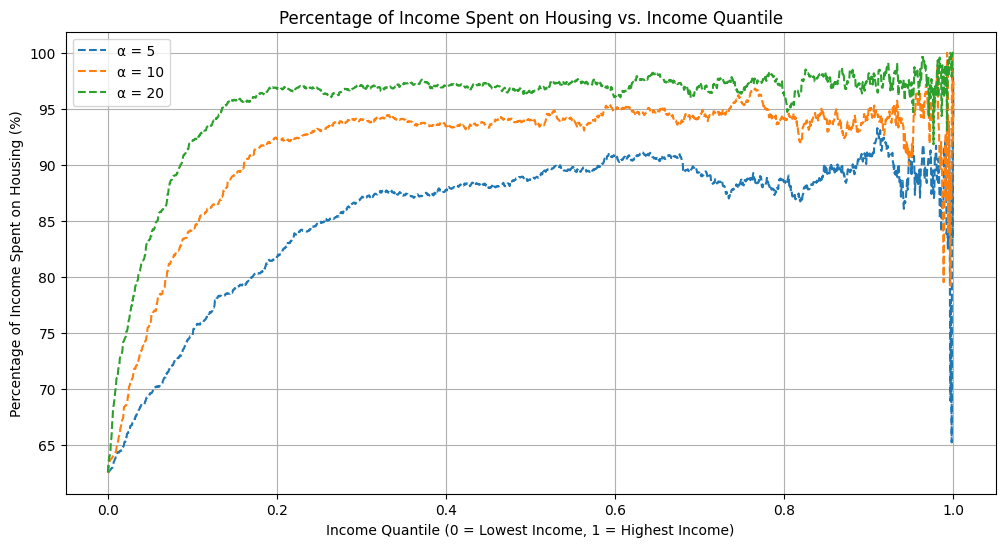

In [203]:
n = 2000
mu_list = [5,10,20]
y_min = 80
alpha = 1.75
c = 50
seed = 1

# Initialize lists to collect statistics and data
stats_list = []
all_y = []  # Store income data
all_prices = []  # Store price data

# Iterate over each alpha
for mu in mu_list:

    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['mu'] = mu  
    stats_list.append(stats)

# df for table
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['mu', 'average', 'median', 'Q1', 'Q3', 'IQR']]  
print(stats_df)

# Create plots after the loop
income_quantiles = np.linspace(0, 1, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, mu) in enumerate(zip(all_prices, mu_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'α = {mu}') 
#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, mu) in enumerate(zip(all_y, all_prices, mu_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'α = {mu}')  # Fixed: Label shows alpha
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Population Growth

## Building up

      n     average      median         Q1          Q3        IQR
0  2000  162.065765  110.242318  87.534470  158.437402  70.902932
1  4000  167.930159  112.761881  88.268024  167.156673  78.888649


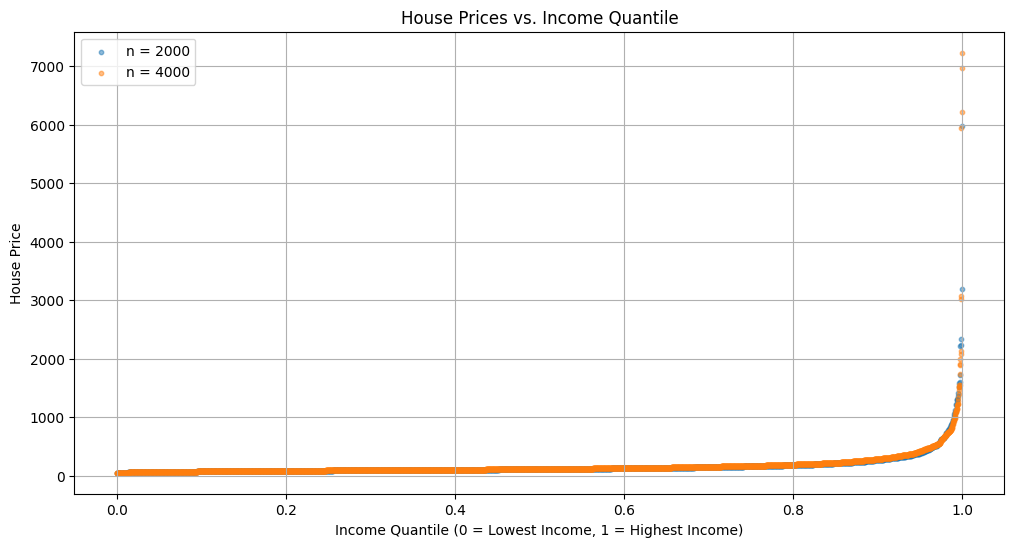

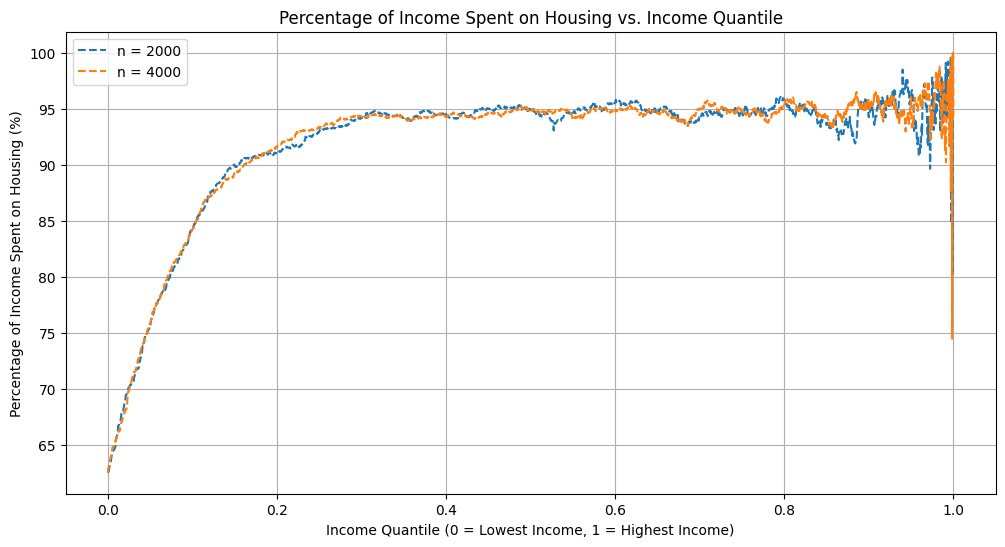

In [204]:
n_list = [2000, 4000]
alpha = 1.75
y_min = 80
mu = 10
c = 50
seed = 1

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices


for n in n_list:

    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d) # the regular recursive approach does not work with n=4000
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats_i = compute_statistics(prices)
    stats_i['n'] = n  
    stats_list.append(stats_i)

# Create a DataFrame for statistics
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['n', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# Create plots after the loop

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for prices, n in zip(all_prices, n_list):
    income_quantiles = np.linspace(0, 1, len(prices))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'n = {n}')
#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for y, prices, n in zip(all_y, all_prices, n_list):
    income_quantiles = np.linspace(0, 1, len(prices))
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'n = {n}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()


## Building out

      n  mu     average      median         Q1          Q3        IQR
0  2000  10  169.969581  114.487087  87.746211  166.178918  78.432707
1  4000  20  176.195554  115.304393  91.506656  171.894470  80.387814


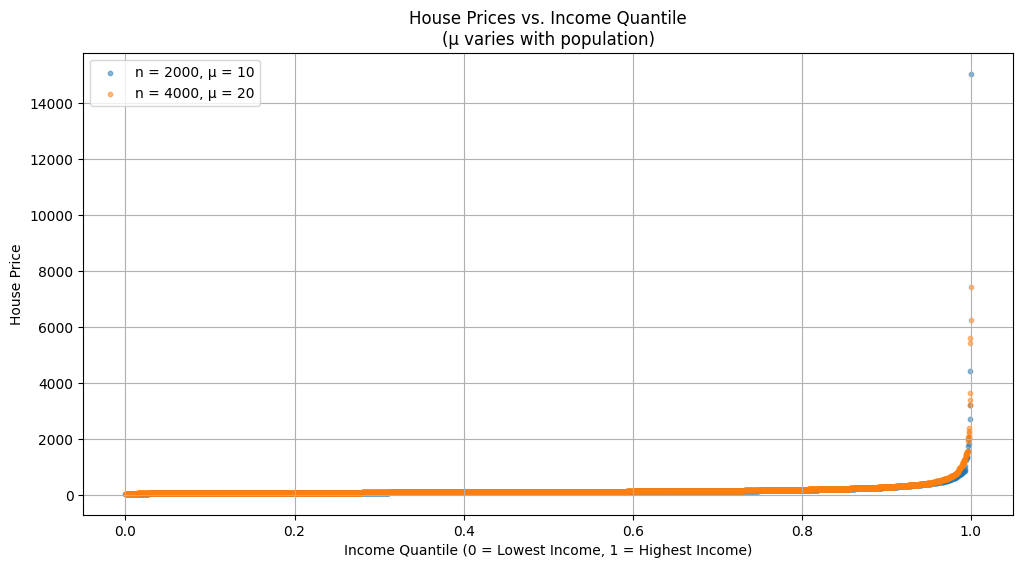

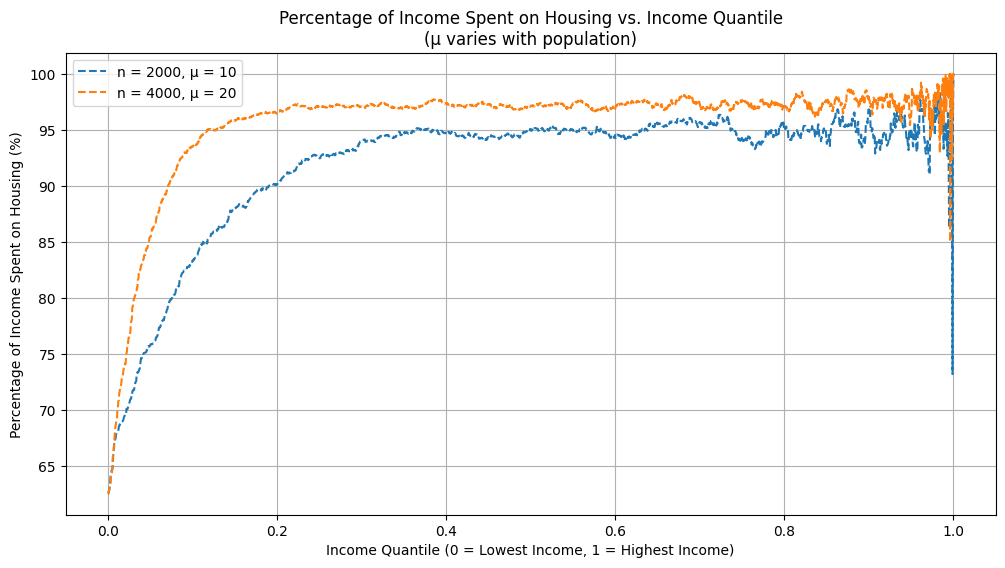

In [205]:
n_list = [2000, 4000]
alpha = 1.75
y_min = 80
c = 50
seed = 1
stats_list = []  # Store stats for table
all_y = []       # Store income data
all_prices = []  # Store prices

# Create dictionary mapping population sizes to mu values
mu_dict = {2000: 10, 4000: 20}  # mu doubles for larger population

for n in n_list:
    # Get appropriate mu for this population size
    mu = mu_dict[n]
    
    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d)
    all_y.append(y)
    all_prices.append(prices)
   
    # Compute statistics
    stats_i = compute_statistics(prices)
    stats_i['n'] = n
    stats_i['mu'] = mu  # Add mu to statistics for reference
    stats_list.append(stats_i)

# Create a DataFrame for statistics
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['n', 'mu', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for prices, n in zip(all_prices, n_list):
    income_quantiles = np.linspace(0, 1, len(prices))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, 
                label=f'n = {n}, μ = {mu_dict[n]}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile\n(μ varies with population)')
plt.grid(True)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for y, prices, n in zip(all_y, all_prices, n_list):
    income_quantiles = np.linspace(0, 1, len(prices))
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', 
             label=f'n = {n}, μ = {mu_dict[n]}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile\n(μ varies with population)')
plt.grid(True)
plt.legend()
plt.show()

## 7

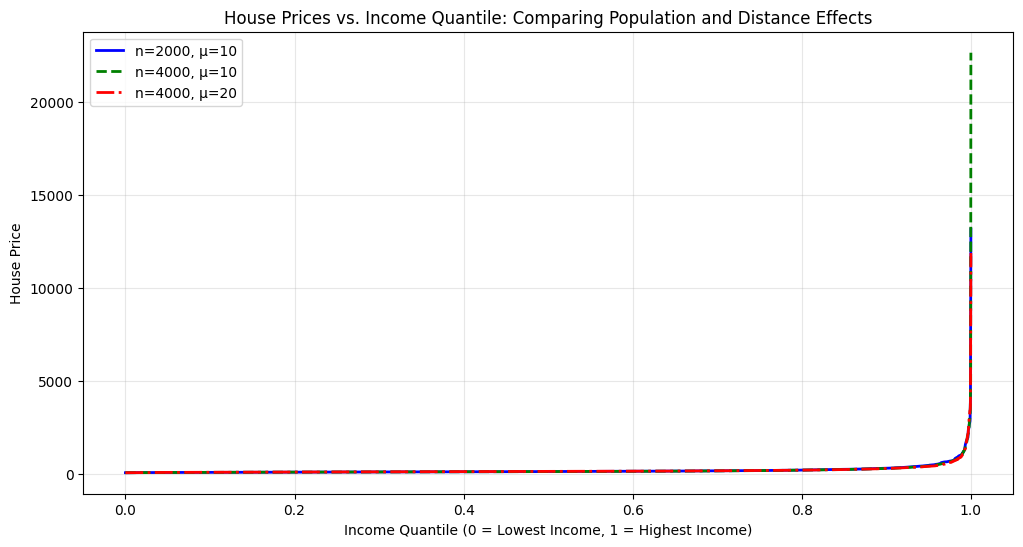

In [206]:
# define dictionary of scenarios because two of the variables change
scenarios = [
    {'n': 2000, 'mu': 10, 'label': 'n=2000, μ=10'},
    {'n': 4000, 'mu': 10, 'label': 'n=4000, μ=10'},
    {'n': 4000, 'mu': 20, 'label': 'n=4000, μ=20'}
]

alpha = 1.75
y_min = 80
c = 50
seed = 1

# Store results
all_prices = []
all_quantiles = []

# Generate data for each scenario
for scenario in scenarios:
    n = scenario['n']
    mu = scenario['mu']
    
    # Generate data and calculate prices
    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store results
    all_prices.append(prices)
    all_quantiles.append(np.linspace(0, 1, len(prices)))

# plot comparison
plt.figure(figsize=(12, 6))

styles = ['-', '--', '-.']
colors = ['blue', 'green', 'red']

for (prices, quantiles, scenario, style, color) in zip(all_prices, all_quantiles, scenarios, styles, colors):
    plt.plot(quantiles, prices, 
             linestyle=style,
             color=color,
             label=scenario['label'],
             linewidth=2)

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile: Comparing Population and Distance Effects')
plt.grid(True, alpha=0.3)
plt.legend()

#plt.xlim(0.98, 1.01) # zoom in

plt.show()



# Tax

## Data gen

In [207]:
def gen_data_with_tax(n,y_min,alpha,mu,c,tau,seed):

    # Validate parameters
    if y_min <= c:
        raise ValueError("y_min needs to be greater than c")
    if alpha <= 1:
        raise ValueError("alpha needs to be greater than 1")
    if mu <= 0:
        raise ValueError("mu needs to be positive")
    if not 0 <= tau < 1:
        raise ValueError("tau must be between 0 and 1")
        
    # Set random seed
    np.random.seed(seed)
    
    # Generate pre-tax incomes (Pareto distribution)
    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)
    
    # Generate distances (exponential distribution)
    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)
    
    # Sort both arrays
    y = np.sort(y)
    d = np.sort(d)
    
    # Calculate average income
    y_bar = np.mean(y)
    
    # Calculate transfer amount (T = τ * y_bar)
    T = tau * y_bar
    
    # Calculate post-tax income for each agent
    x = (1 - tau) * y + T
    x = np.sort(x) # sort (might not be necessary)
    return y, x, d

## Plotting

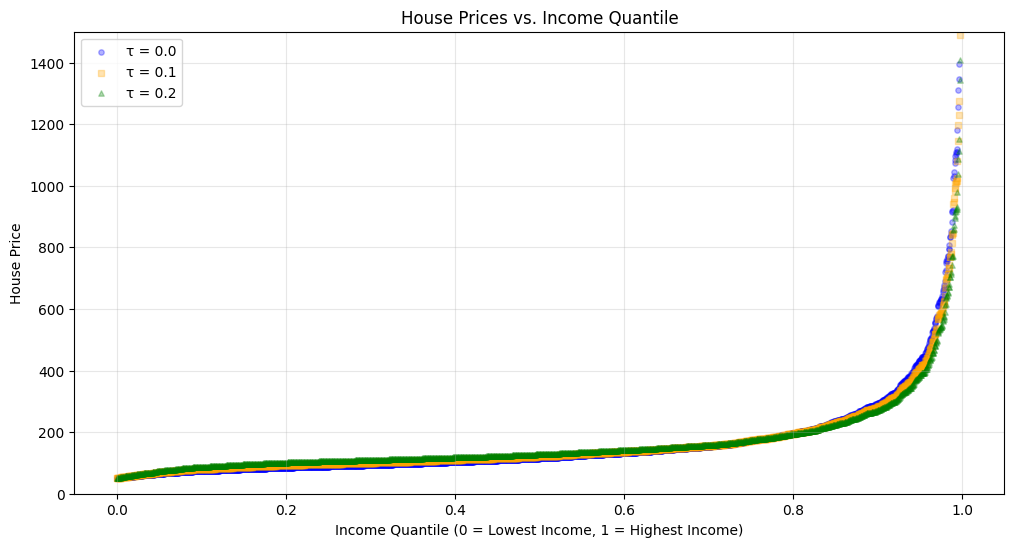

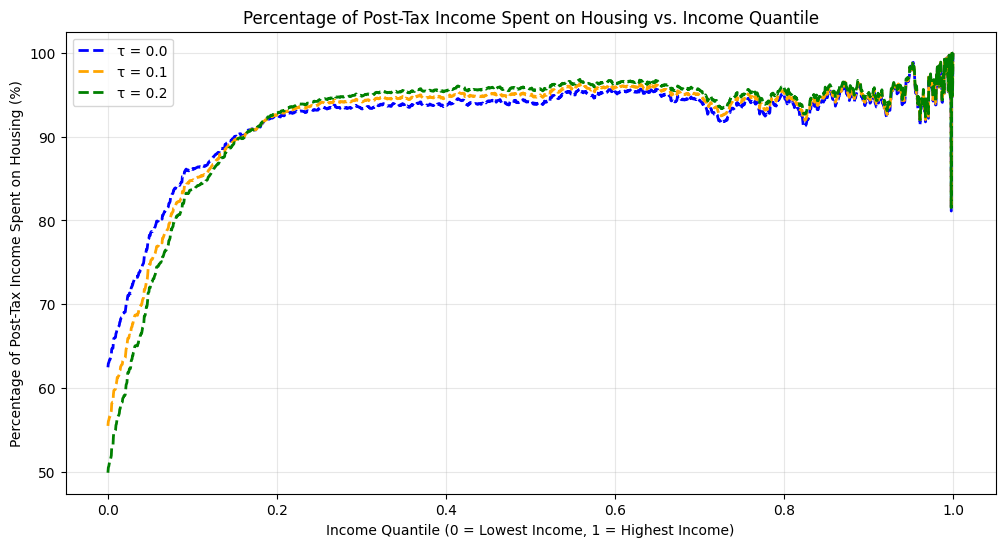

In [208]:
n=2000
y_min=80
alpha=1.75
mu=10
c=50
tau_list=[0.0,0.1,0.2]
seed=1

# Store data for all tax rates
all_y = []      # pre-tax incomes
all_x = []      # post-tax incomes
all_prices = []
for tau in tau_list:
    y, x, d = gen_data_with_tax(n, y_min, alpha, mu, c, tau, seed)
    # Use post-tax income (x) for price calculations instead of pre-tax income (y)
    prices = calc_prices_iterative(n, c, x, d)  # Changed y to x here
    all_y.append(y)
    all_x.append(x)
    all_prices.append(prices)

income_quantiles = np.linspace(0, 1, n)

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green']
markers = ['o', 's', '^']
for prices, tau, color, marker in zip(all_prices, tau_list, colors, markers):
    plt.scatter(income_quantiles, prices, 
               s=15,
               alpha=0.3,
               color=color,
               marker=marker,
               label=f'τ = {tau}')
plt.ylim(0, 1500)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent (using post-tax income)
plt.figure(figsize=(12, 6))
for x, prices, tau, color in zip(all_x, all_prices, tau_list, colors):  # Using x instead of y
    percentage_spent = np.where(x != 0, (prices / x) * 100, 0)  # Changed y to x here
    plt.plot(income_quantiles, percentage_spent, 
            linestyle='--', 
            color=color,
            linewidth=2,
            label=f'τ = {tau}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Post-Tax Income Spent on Housing (%)')  # Updated label
plt.title('Percentage of Post-Tax Income Spent on Housing vs. Income Quantile')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Low Income Housing

In [209]:
def gen_restricted_data(n, y_min, alpha, mu, c, seed=1):
    """
    Generates sorted incomes and house distances with housing controls.

    Parameters:
    - n (int): Number of agents and houses (must be even).
    - y_min (float): Minimum income, must be greater than the marginal cost c.
    - alpha (float): Parameter controlling income distribution, must be > 1.
    - mu (float): Parameter controlling distance distribution, must be positive.
    - c (float): Marginal cost of building/maintaining each house.
    - seed (int): Random seed for reproducibility.

    Returns:
    - y (np.ndarray): Sorted incomes in descending order.
    - d (np.ndarray): Sorted house distances in ascending order.
    - restricted_houses (np.ndarray): Boolean array indicating restricted houses.
    - high_income_agents (np.ndarray): Boolean array indicating high-income agents.
    - low_income_agents (np.ndarray): Boolean array indicating low-income agents.
    """

    # Validate parameters
    if y_min <= c:
        raise ValueError("y_min needs to be greater than c")
    if alpha <= 1:
        raise ValueError("alpha needs to be greater than 1")
    if mu <= 0:
        raise ValueError("mu needs to be positive")
    if n % 2 != 0:
        raise ValueError("n must be even")

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate incomes using a Pareto-like distribution
    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

    # Generate house distances using an exponential distribution
    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)

    # Sort incomes in descending order and distances in ascending order
    y = np.sort(y)[::-1]
    d = np.sort(d)

    # Identify restricted houses: every third house (1-based indexing: 3, 6, 9, ...)
    # In 0-based indexing: indices 2, 5, 8, ...
    restricted_houses = np.zeros(n, dtype=bool)
    restricted_houses[2::3] = True  # Set every third house as restricted

    # Split agents into high-income and low-income groups
    # Since n is even, the median splits the agents exactly in half
    m = n // 2
    high_income_agents = np.zeros(n, dtype=bool)
    high_income_agents[:m] = True          # First half are high-income
    low_income_agents = ~high_income_agents  # Second half are low-income

    return y, d, restricted_houses, high_income_agents, low_income_agents


In [ ]:

# Example parameters
n=2000
y_min=80
alpha=1.75
mu=10
c=50
seed = 1

# Generate data
y, d, restricted_houses, high_income_agents, low_income_agents = gen_restricted_data(n, y_min, alpha, mu, c, seed)

# Display the results
print("Incomes (sorted descendingly):")
print(y)

print("\nHouse Distances (sorted ascendingly):")
print(d)

print("\nRestricted Houses (True indicates restricted):")
print(restricted_houses)

print("\nHigh-Income Agents (True indicates high-income):")
print(high_income_agents)

print("\nLow-Income Agents (True indicates low-income):")
print(low_income_agents)

Incomes (sorted descendingly):
[3312.59495811 3183.08092468 2700.22145471 ...   80.03496434   80.01838409
   80.00522903]

House Distances (sorted ascendingly):
[1.24220141e-03 1.40189361e-02 1.68466797e-02 ... 7.20762740e+01
 7.82810410e+01 9.24130808e+01]

Restricted Houses (True indicates restricted):
[False False  True ...  True False False]

High-Income Agents (True indicates high-income):
[ True  True  True ... False False False]

Low-Income Agents (True indicates low-income):
[False False False ...  True  True  True]



## Running DocTest tests

This last step gets the DocTest system to check test cases in the documentation comments.
In this course, you won't need to modify the stuff below, or even understand the details.

In [211]:
import doctest
result = doctest.testmod(verbose=False)
if result[0] == 0:
    print(("Congratulations! You have passed all "+str(result[1])+" tests"))
else:
    print("Rats!")

Congratulations! You have passed all 0 tests
